In [1]:
import sys, os, json, random
import torch
import sys
import datetime
import cv2
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
%matplotlib inline
from shapely.geometry import Polygon
data_dir = "/kaggle/input/car-parts-and-car-damages/Car parts dataset/File1/"
os.makedirs("/kaggle/working/data/", exist_ok=True)
os.makedirs("/kaggle/working/data/train/", exist_ok=True)
os.makedirs("/kaggle/working/data/val/", exist_ok=True)
os.makedirs("/kaggle/working/model/", exist_ok=True)
data_working_dir = "/kaggle/working/data/"
model_dir = "/kaggle/working/model/"

In [2]:
import json
import os
import shutil
import random
from PIL import Image


data_dir = "/kaggle/input/car-parts-and-car-damages/Car parts dataset/File1/"
images_dir = os.path.join(data_dir, "img")
annotations_dir = os.path.join(data_dir, "ann")

os.makedirs("/kaggle/working/data/train", exist_ok=True)
os.makedirs("/kaggle/working/data/val", exist_ok=True)

data_working_dir = "/kaggle/working/data/"
images = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
random.shuffle(images)
split_index = int(0.8 * len(images))
train_images = images[:split_index]
val_images = images[split_index:]

def convert_to_coco(images, images_dir, annotations_dir, output_dir):
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    category_mapping = {
        "Dent": 1,
        "Scratch": 2,
        "Broken part": 3,
        "Paint chip": 4,
        "Missing part": 5,
        "Flaking": 6,
        "Corrosion": 7,
        "Cracked": 8
    }

    for category, id in category_mapping.items():
        coco_output["categories"].append({
            "id": id,
            "name": category
        })

    annotation_id = 1
    for idx, image_filename in enumerate(images):
        image_path = os.path.join(images_dir, image_filename)
        annotation_path = os.path.join(annotations_dir, image_filename + ".json")
        
        # Copy the image to the output directory
        shutil.copy(image_path, output_dir)
        
        # Open the image to get its dimensions
        with Image.open(image_path) as img:
            width, height = img.size
        
        coco_output["images"].append({
            "file_name": image_filename,
            "height": height,
            "width": width,
            "id": idx
        })
        
        with open(annotation_path) as f:
            objs = json.load(f)["objects"]

        for obj in objs:
            px = [point[0] for point in obj["points"]["exterior"]]
            py = [point[1] for point in obj["points"]["exterior"]]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            category_id = category_mapping.get(obj["classTitle"], -1)
            if category_id == -1:
                continue  # Skip unknown categories
            
            bbox = [min(px), min(py), max(px) - min(px), max(py) - min(py)]
            
            coco_output["annotations"].append({
                "bbox": bbox,
                "category_id": category_id,
                "image_id": idx,
                "segmentation": [poly],
                "area": bbox[2] * bbox[3],
                "iscrowd": 0,
                "id": annotation_id
            })
            annotation_id += 1

    return coco_output

train_output = convert_to_coco(train_images, images_dir, annotations_dir, os.path.join(data_working_dir, "train"))
val_output = convert_to_coco(val_images, images_dir, annotations_dir, os.path.join(data_working_dir, "val"))

with open(os.path.join(data_working_dir, "train", "annotations.json"), "w") as f:
    json.dump(train_output, f, indent=4)

with open(os.path.join(data_working_dir, "val", "annotations.json"), "w") as f:
    json.dump(val_output, f, indent=4)


In [3]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-jgxx7xvs
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-jgxx7xvs
  Resolved https://github.com/facebookresearch/detectron2.git to commit 2a420edb307c9bdf640f036d3b196bed474b8593
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48

In [4]:
from detectron2.data.datasets import register_coco_instances

# Register train and val datasets
register_coco_instances("car_train", {}, os.path.join(data_working_dir, "train", "annotations.json"), os.path.join(data_working_dir, "train"))
register_coco_instances("car_val", {}, os.path.join(data_working_dir, "val", "annotations.json"), os.path.join(data_working_dir, "val"))

# Load metadata
from detectron2.data import MetadataCatalog
car_metadata = MetadataCatalog.get("car_train")
print(car_metadata)

Metadata(name='car_train', json_file='/kaggle/working/data/train/annotations.json', image_root='/kaggle/working/data/train', evaluator_type='coco')


{'file_name': '/kaggle/working/data/train/Car damages 466.png', 'height': 622, 'width': 1122, 'image_id': 0, 'annotations': [{'iscrowd': 0, 'bbox': [504.0, 359.0, 80.0, 43.0], 'category_id': 1, 'segmentation': [[520.0, 384.0, 521.0, 379.0, 531.0, 376.0, 535.0, 374.0, 544.0, 370.0, 552.0, 368.0, 563.0, 363.0, 573.0, 359.0, 584.0, 359.0, 579.0, 364.0, 569.0, 368.0, 565.0, 370.0, 561.0, 375.0, 556.0, 381.0, 550.0, 387.0, 545.0, 388.0, 535.0, 391.0, 528.0, 393.0, 520.0, 394.0, 512.0, 397.0, 507.0, 402.0, 504.0, 400.0, 507.0, 395.0, 511.0, 392.0, 516.0, 389.0]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [619.0, 377.0, 101.0, 98.0], 'category_id': 1, 'segmentation': [[644.0, 455.0, 648.0, 451.0, 651.0, 453.0, 655.0, 449.0, 661.0, 442.0, 666.0, 445.0, 672.0, 450.0, 677.0, 446.0, 681.0, 451.0, 685.0, 449.0, 693.0, 443.0, 697.0, 439.0, 703.0, 433.0, 708.0, 430.0, 714.0, 424.0, 719.0, 426.0, 720.0, 421.0, 720.0, 414.0, 718.0, 409.0, 716.0, 403.0, 713.0, 397.0, 706.0, 390.0, 702

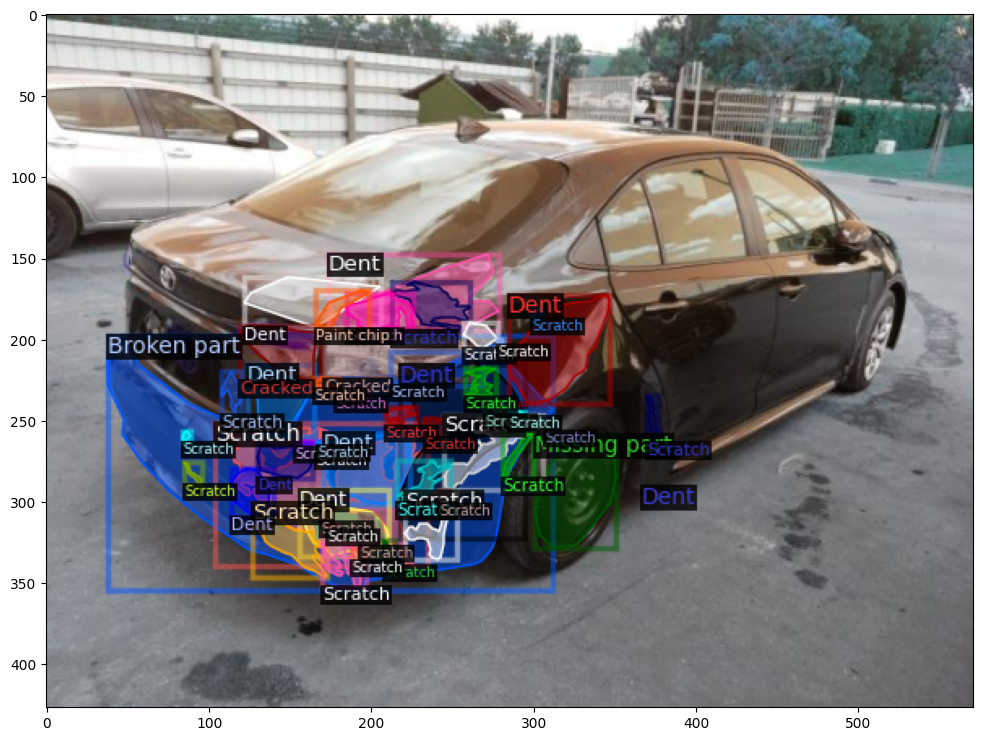

In [5]:
import random
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog

dataset_dicts = DatasetCatalog.get("car_train")
print(dataset_dicts[0])
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=car_metadata)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()    

In [6]:
import os
import torch
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor, hooks, HookBase
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Create output directory with timestamp
output_dir = "./output_" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs(output_dir, exist_ok=True)

# Set up configuration for training
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.OUTPUT_DIR = output_dir
cfg.DATASETS.TRAIN = ("car_train",)
cfg.DATASETS.TEST = ("car_val",)  # for evaluation during training
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000  # Increase the maximum number of iterations
cfg.SOLVER.STEPS = []  # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 8
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # total number of classes

# Custom Trainer to add hooks for status updates
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(0, PrintTrainingStatus())
        return hooks

# Custom hook to print training status
class PrintTrainingStatus(HookBase):
    def after_step(self):
        if self.trainer.iter % 100 == 0 or self.trainer.iter == self.trainer.max_iter:
            print(f"Iteration {self.trainer.iter}/{self.trainer.max_iter} - Loss: {self.trainer.storage.latest()['total_loss']}")

# Create a trainer
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Setup for evaluation
cfg.OUTPUT_DIR = output_dir
os.makedirs("/kaggle/working/val_results/", exist_ok=True)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("car_val",)

# Create predictor and evaluator
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("car_val", cfg, False, output_dir="/kaggle/working/val_results/")
val_loader = build_detection_test_loader(cfg, "car_val")

# Run inference and evaluation
metrics = inference_on_dataset(predictor.model, val_loader, evaluator)
print(metrics)

model_final_f10217.pkl: 178MB [00:01, 149MB/s]                             
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 0/3000 - Loss: (6.535291969776154, 0)


2024-07-25 19:35:39.378934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 19:35:39.379044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 19:35:39.519866: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Iteration 100/3000 - Loss: (2.9363459199666977, 100)
Iteration 200/3000 - Loss: (2.363116428256035, 200)
Iteration 300/3000 - Loss: (2.6142376512289047, 300)
Iteration 400/3000 - Loss: (2.8123330622911453, 400)
Iteration 500/3000 - Loss: (2.2925024926662445, 500)
Iteration 600/3000 - Loss: (2.3172619193792343, 600)
Iteration 700/3000 - Loss: (2.4238343834877014, 700)
Iteration 800/3000 - Loss: (2.4068828523159027, 800)
Iteration 900/3000 - Loss: (2.638286828994751, 900)
Iteration 1000/3000 - Loss: (2.1764988973736763, 1000)
Iteration 1100/3000 - Loss: (2.24033984541893, 1100)
Iteration 1200/3000 - Loss: (2.3206191062927246, 1200)
Iteration 1300/3000 - Loss: (1.8383079543709755, 1300)
Iteration 1400/3000 - Loss: (2.2870803624391556, 1400)
Iteration 1500/3000 - Loss: (2.0673038214445114, 1500)
Iteration 1600/3000 - Loss: (1.7766241803765297, 1600)
Iteration 1700/3000 - Loss: (1.937717817723751, 1700)
Iteration 1800/3000 - Loss: (1.6189649663865566, 1800)
Iteration 1900/3000 - Loss: (2.41

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.052
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.052
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.

In [7]:
import os
import torch
from detectron2.engine import DefaultPredictor

# Set the path to the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# Set a custom testing threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Create a predictor
predictor = DefaultPredictor(cfg)

{'instances': Instances(num_instances=12, image_height=419, image_width=637, fields=[pred_boxes: Boxes(tensor([[328.1581, 169.3661, 430.7960, 244.3743],
        [203.3057, 160.8712, 335.1428, 225.2120],
        [199.0156, 152.7220, 406.1735, 247.7617],
        [190.3598, 159.9723, 258.1968, 209.9251],
        [288.0552, 161.4615, 334.2346, 226.3237],
        [329.3990, 147.8793, 339.9018, 242.5172],
        [193.3091, 162.6617, 274.8713, 234.0629],
        [229.4244, 160.1426, 255.9138, 206.2254],
        [331.3193, 162.4264, 372.8000, 242.0533],
        [192.8889, 170.2849, 233.3797, 207.2640],
        [273.8959, 153.7086, 468.0833, 247.6477],
        [187.9217, 167.9780, 204.6936, 236.0483]], device='cuda:0')), scores: tensor([0.8652, 0.8503, 0.7568, 0.7245, 0.6723, 0.6420, 0.5907, 0.5836, 0.5699,
        0.5638, 0.5450, 0.5067], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False

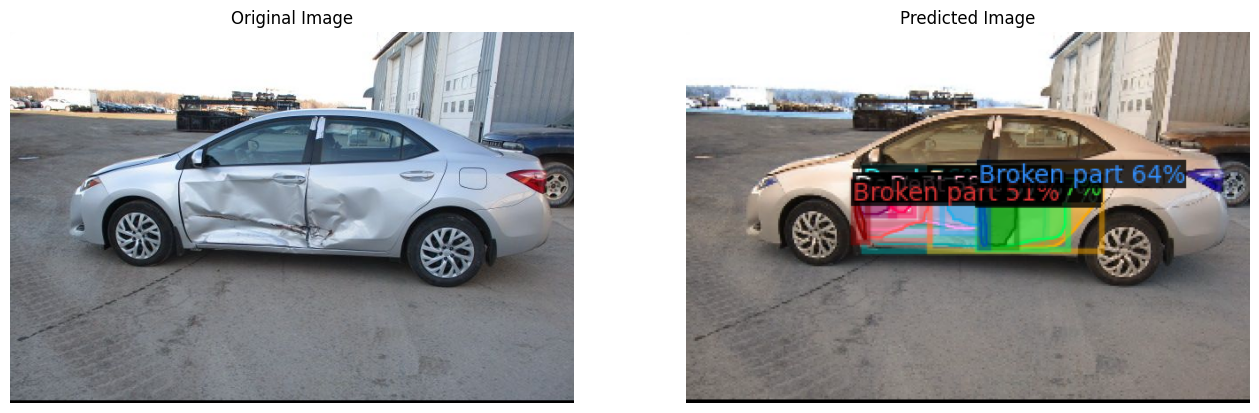

In [8]:
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer


# Load image
im = cv2.imread('/kaggle/input/car-parts-and-car-damages/Car damages dataset/File1/img/Car damages 100.png')

# Make predictions using the predictor
output = predictor(im)

print(output)

# Visualize original image
plt.subplot(1, 2, 1)
plt.imshow(im[:, :, ::-1])
plt.title('Original Image')
plt.axis('off')

# Draw the predictions on the test image
v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
out = v.draw_instance_predictions(output["instances"].to("cpu"))

# Show the image with predictions
plt.subplot(1, 2, 2)
plt.imshow(out.get_image()[:, :, ::-1])
plt.title('Predicted Image')
plt.axis('off')

plt.show()


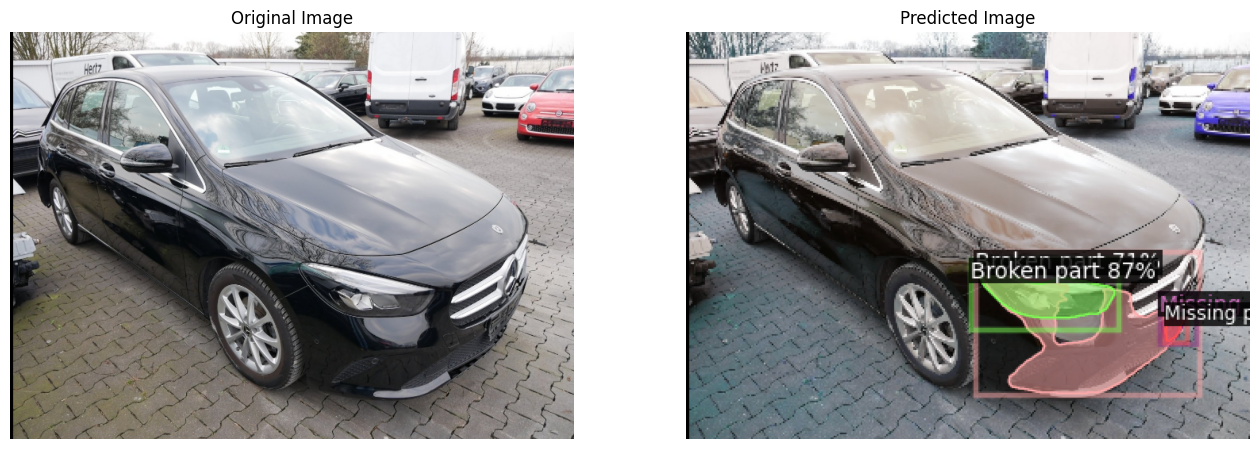

In [9]:
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Load image
# im = cv2.imread('/kaggle/input/car-parts-and-car-damages/Car damages dataset/File1/img/Car damages 100.png')
im = cv2.imread("/kaggle/input/car-parts-and-car-damages/Car parts dataset/File1/img/Car damages 1082.png")

# Make predictions using the predictor
output = predictor(im)

# Visualize original image
plt.subplot(1, 2, 1)
plt.imshow(im[:, :, ::-1])
plt.title('Original Image')
plt.axis('off')

# Draw the predictions on the test image
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)

# Load color mapping from meta.json
class_colors = {
    "Missing part": "#13A4C9",
    "Broken part": "#A6FF47",
    "Scratch": "#B42D38",
    "Cracked": "#E19660",
    "Dent": "#903C59",
    "Flaking": "#A7741B",
    "Paint chip": "#B40E13",
    "Corrosion": "#73C2CE"
}

# Apply class colors to visualizer
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
metadata.thing_colors = class_colors

out = v.draw_instance_predictions(output["instances"].to("cpu"))

# Show the image with predictions
plt.subplot(1, 2, 2)
plt.imshow(out.get_image()[:, :, ::-1])
plt.title('Predicted Image')
plt.axis('off')

plt.show()


In [10]:
# Save the trained model
output_model_path = os.path.join(model_dir, f"mask_rcnn_model_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pth")
torch.save(trainer.model.state_dict(), output_model_path)
print("Model saved successfully at:", output_model_path)

Model saved successfully at: /kaggle/working/model/mask_rcnn_model_20240725_202138.pth


/tmp/ipykernel_34/3511243454.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  merged_boxes_tensor = torch.tensor(merged_boxes, dtype=torch.float32)


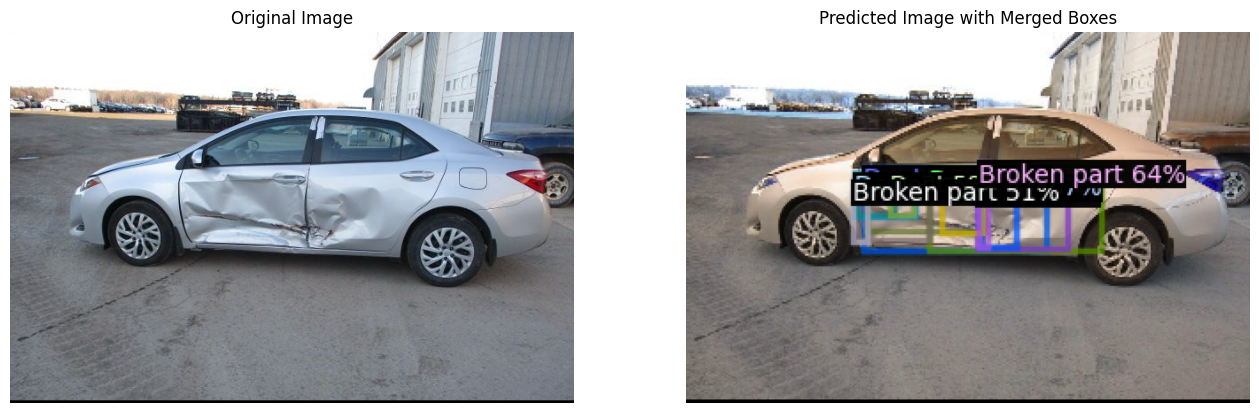

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import Boxes, Instances
from shapely.geometry import box

# Load image
im = cv2.imread('/kaggle/input/car-parts-and-car-damages/Car damages dataset/File1/img/Car damages 100.png')

# Make predictions using the predictor
output = predictor(im)

# Extract bounding boxes and scores
instances = output["instances"].to("cpu")
boxes = instances.pred_boxes.tensor.numpy()
scores = instances.scores.numpy()
classes = instances.pred_classes.numpy()

# Function to calculate IoU
def calculate_iou(box1, box2):
    box1 = box(*box1)
    box2 = box(*box2)
    intersection = box1.intersection(box2).area
    union = box1.union(box2).area
    return intersection / union

# Merge boxes based on IoU
iou_threshold = 0.5

def merge_boxes(boxes, scores, classes, iou_threshold):
    merged = True
    while merged:
        merged = False
        new_boxes = []
        new_scores = []
        new_classes = []
        skip = set()
        for i in range(len(boxes)):
            if i in skip:
                continue
            box1 = boxes[i]
            new_box = box1.copy()
            new_score = scores[i]
            new_class = classes[i]
            for j in range(i + 1, len(boxes)):
                if j in skip:
                    continue
                box2 = boxes[j]
                iou = calculate_iou(box1, box2)
                if iou > iou_threshold:
                    new_box[0] = min(new_box[0], box2[0])
                    new_box[1] = min(new_box[1], box2[1])
                    new_box[2] = max(new_box[2], box2[2])
                    new_box[3] = max(new_box[3], box2[3])
                    new_score = max(new_score, scores[j])
                    new_class = classes[i]  # Assuming same class for simplicity; modify as needed
                    skip.add(j)
                    merged = True
            new_boxes.append(new_box)
            new_scores.append(new_score)
            new_classes.append(new_class)
        boxes = [boxes[i] for i in range(len(boxes)) if i not in skip]
        scores = [scores[i] for i in range(len(scores)) if i not in skip]
        classes = [classes[i] for i in range(len(classes)) if i not in skip]
        boxes.extend(new_boxes)
        scores.extend(new_scores)
        classes.extend(new_classes)
    return boxes, scores, classes

merged_boxes, merged_scores, merged_classes = merge_boxes(boxes, scores, classes, iou_threshold)

# Convert merged boxes, scores, and classes to Detectron2 Instances object
merged_boxes_tensor = torch.tensor(merged_boxes, dtype=torch.float32)
merged_scores_tensor = torch.tensor(merged_scores, dtype=torch.float32)
merged_classes_tensor = torch.tensor(merged_classes, dtype=torch.int64)

# Create a new Instances object with the merged results
merged_instances = Instances(instances.image_size)
merged_instances.pred_boxes = Boxes(merged_boxes_tensor)
merged_instances.scores = merged_scores_tensor
merged_instances.pred_classes = merged_classes_tensor

# Visualize original image
plt.subplot(1, 2, 1)
plt.imshow(im[:, :, ::-1])
plt.title('Original Image')
plt.axis('off')

# Draw the predictions on the test image
v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
out = v.draw_instance_predictions(merged_instances)

# Show the image with predictions
plt.subplot(1, 2, 2)
plt.imshow(out.get_image()[:, :, ::-1])
plt.title('Predicted Image with Merged Boxes')
plt.axis('off')
plt.show()

{'instances': Instances(num_instances=16, image_height=475, image_width=709, fields=[pred_boxes: Boxes(tensor([[ 67.8446, 297.4781, 148.4318, 352.2920],
        [461.3538, 197.9425, 562.9521, 333.9226],
        [568.6047, 162.7580, 628.3815, 253.9393],
        [543.0630, 169.6648, 620.3693, 301.8493],
        [ 83.4070, 156.1991, 395.0851, 251.0100],
        [503.1429, 181.8842, 610.4359, 312.7759],
        [ 76.9354, 229.2962, 295.7087, 293.0042],
        [503.3030, 202.2749, 558.9321, 308.2574],
        [227.7285, 183.2401, 379.3547, 239.0484],
        [126.8710, 248.7518, 299.6767, 283.5450],
        [587.1368, 167.0772, 624.3871, 238.0603],
        [481.4816, 274.7588, 539.6348, 294.8011],
        [548.7820, 227.4284, 608.9992, 296.4308],
        [ 69.7717, 286.1792, 333.2756, 422.0930],
        [548.2444, 231.5646, 611.9005, 303.5005],
        [543.7660, 261.0380, 560.5095, 310.4735]], device='cuda:0')), scores: tensor([0.9652, 0.9074, 0.8500, 0.8424, 0.7411, 0.7408, 0.7123, 0.667

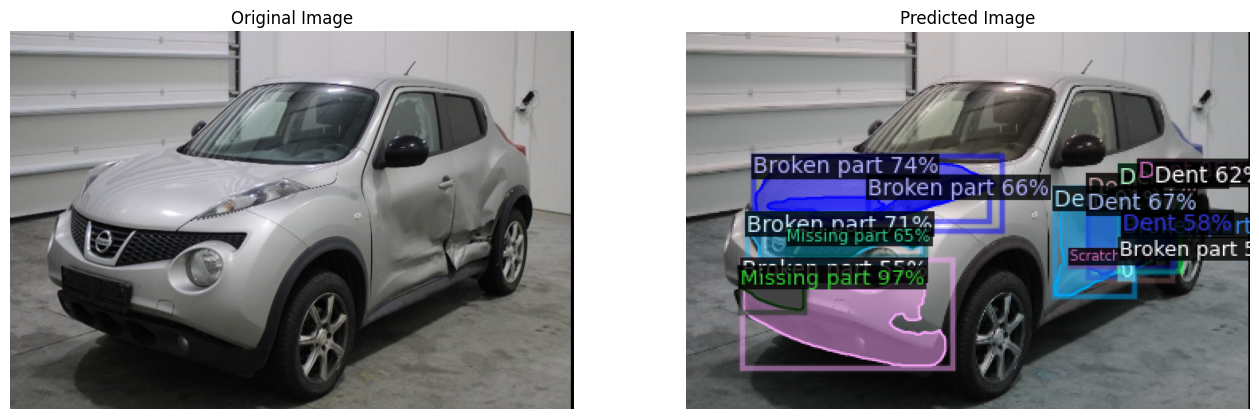

In [12]:
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer


# Load image
im = cv2.imread('/kaggle/input/car-parts-and-car-damages/Car parts dataset/File1/img/Car damages 1070.png')

# Make predictions using the predictor
output = predictor(im)

print(output)

# Visualize original image
plt.subplot(1, 2, 1)
plt.imshow(im[:, :, ::-1])
plt.title('Original Image')
plt.axis('off')

# Draw the predictions on the test image
v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
out = v.draw_instance_predictions(output["instances"].to("cpu"))

# Show the image with predictions
plt.subplot(1, 2, 2)
plt.imshow(out.get_image()[:, :, ::-1])
plt.title('Predicted Image')
plt.axis('off')

plt.show()


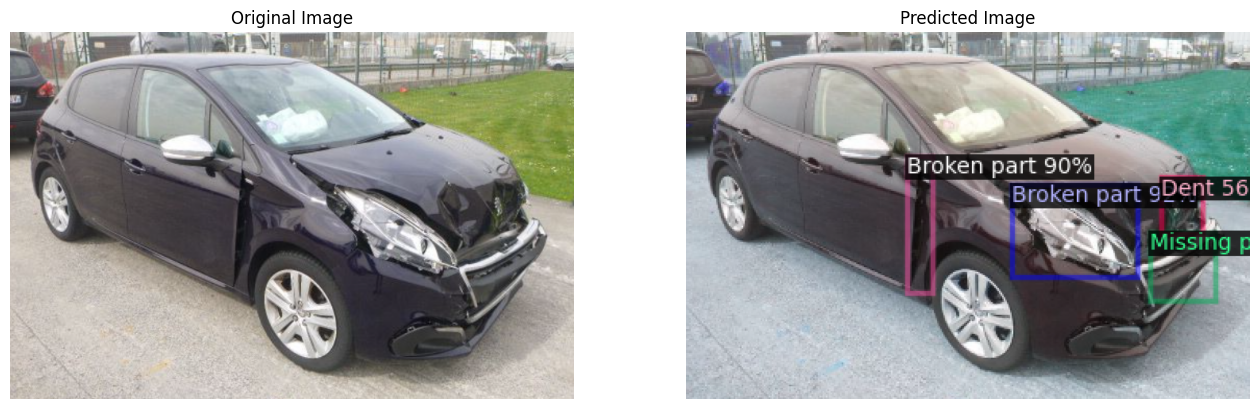

In [13]:
import cv2
import matplotlib.pyplot as plt
import torch

# Load image
im = cv2.imread('/kaggle/input/car-parts-and-car-damages/Car parts dataset/File1/img/Car damages 1077.png')



# Make predictions using the predictor
output = predictor(im)

# Extract bounding boxes, scores, and classes
boxes = output["instances"].pred_boxes.tensor.cpu()
scores = output["instances"].scores.cpu()
classes = output["instances"].pred_classes.cpu()

# Perform Non-Maximum Suppression (NMS) to merge overlapping boxes
keep = torch.ops.torchvision.nms(boxes, scores,0.05)

# Create a new Instances object with the NMS boxes
nms_instances = Instances(output["instances"].image_size)
nms_instances.pred_boxes = Boxes(boxes[keep])
nms_instances.scores = scores[keep]
nms_instances.pred_classes = classes[keep]

# Visualize original image
plt.subplot(1, 2, 1)
plt.imshow(im[:, :, ::-1])
plt.title('Original Image')
plt.axis('off')

# Draw the NMS predictions on the image
v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
out = v.draw_instance_predictions(nms_instances.to('cpu'))

# Show the image with predictions
plt.subplot(1, 2, 2)
plt.imshow(out.get_image()[:, :, ::-1])
plt.title('Predicted Image')
plt.axis('off')

plt.show()


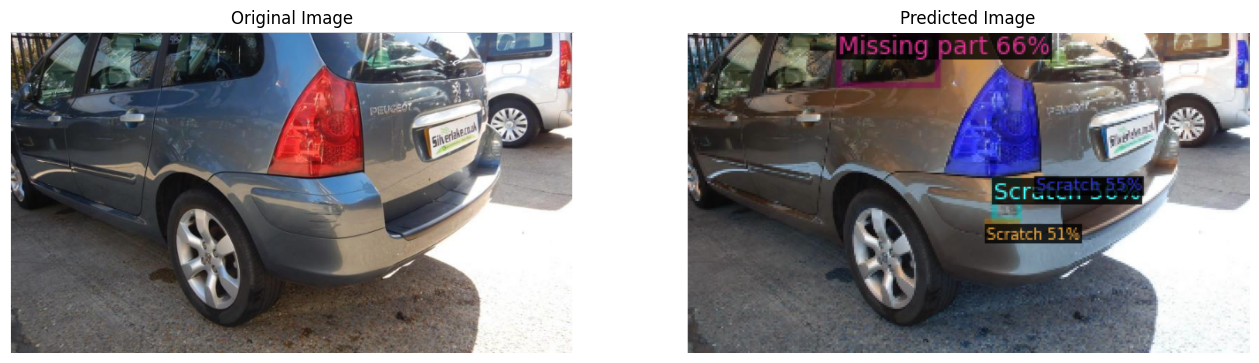

In [14]:
import cv2
import matplotlib.pyplot as plt
import torch

# Load image
im = cv2.imread('/kaggle/input/car-parts-and-car-damages/Car parts dataset/File1/img/Car damages 107.png')



# Make predictions using the predictor
output = predictor(im)

# Extract bounding boxes, scores, and classes
boxes = output["instances"].pred_boxes.tensor.cpu()
scores = output["instances"].scores.cpu()
classes = output["instances"].pred_classes.cpu()

# Perform Non-Maximum Suppression (NMS) to merge overlapping boxes
keep = torch.ops.torchvision.nms(boxes, scores,0.05)

# Create a new Instances object with the NMS boxes
nms_instances = Instances(output["instances"].image_size)
nms_instances.pred_boxes = Boxes(boxes[keep])
nms_instances.scores = scores[keep]
nms_instances.pred_classes = classes[keep]

# Visualize original image
plt.subplot(1, 2, 1)
plt.imshow(im[:, :, ::-1])
plt.title('Original Image')
plt.axis('off')

# Draw the NMS predictions on the image
v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
out = v.draw_instance_predictions(nms_instances.to('cpu'))

# Show the image with predictions
plt.subplot(1, 2, 2)
plt.imshow(out.get_image()[:, :, ::-1])
plt.title('Predicted Image')
plt.axis('off')

plt.show()


{'instances': Instances(num_instances=8, image_height=440, image_width=713, fields=[pred_boxes: Boxes(tensor([[538.7374, 196.3972, 657.1392, 213.6282],
        [ 57.4048, 129.7682, 116.7817, 193.1205],
        [278.5614, 113.5308, 447.7639, 178.4383],
        [ 79.7637, 100.3090, 146.9082, 115.7258],
        [580.9532, 197.9934, 669.1349, 230.5048],
        [540.3101, 186.2035, 653.9949, 207.3157],
        [ 73.8775, 180.1962, 117.5608, 218.6038],
        [575.2383, 220.9480, 612.8561, 227.5947]], device='cuda:0')), scores: tensor([0.9320, 0.7194, 0.6525, 0.6385, 0.6129, 0.6016, 0.5290, 0.5195],
       device='cuda:0'), pred_classes: tensor([2, 2, 4, 2, 2, 2, 0, 1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, F

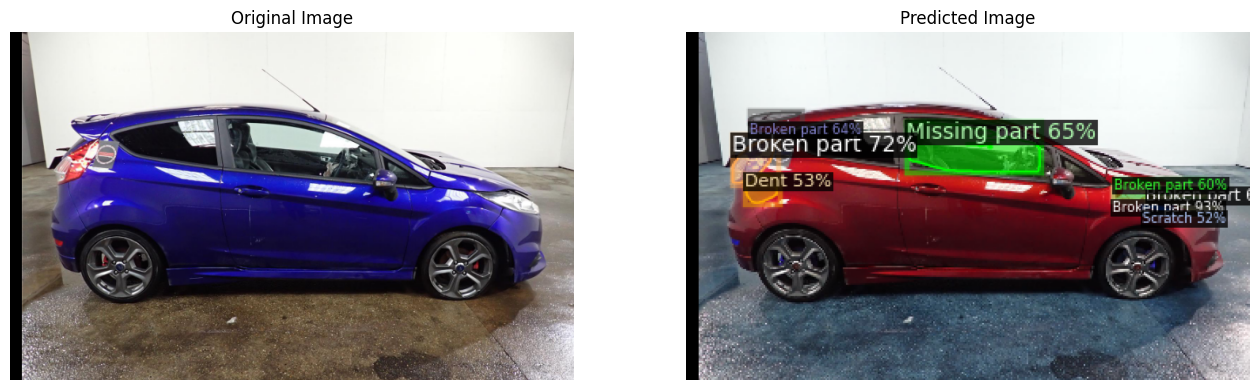

In [15]:
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer


# Load image
im = cv2.imread("/kaggle/input/car-parts-and-car-damages/Car parts dataset/File1/img/Car damages 1087.png")

# Make predictions using the predictor
output = predictor(im)

print(output)

# Visualize original image
plt.subplot(1, 2, 1)
plt.imshow(im[:, :, ::-1])
plt.title('Original Image')
plt.axis('off')

# Draw the predictions on the test image
v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
out = v.draw_instance_predictions(output["instances"].to("cpu"))

# Show the image with predictions
plt.subplot(1, 2, 2)
plt.imshow(out.get_image()[:, :, ::-1])
plt.title('Predicted Image')
plt.axis('off')

plt.show()


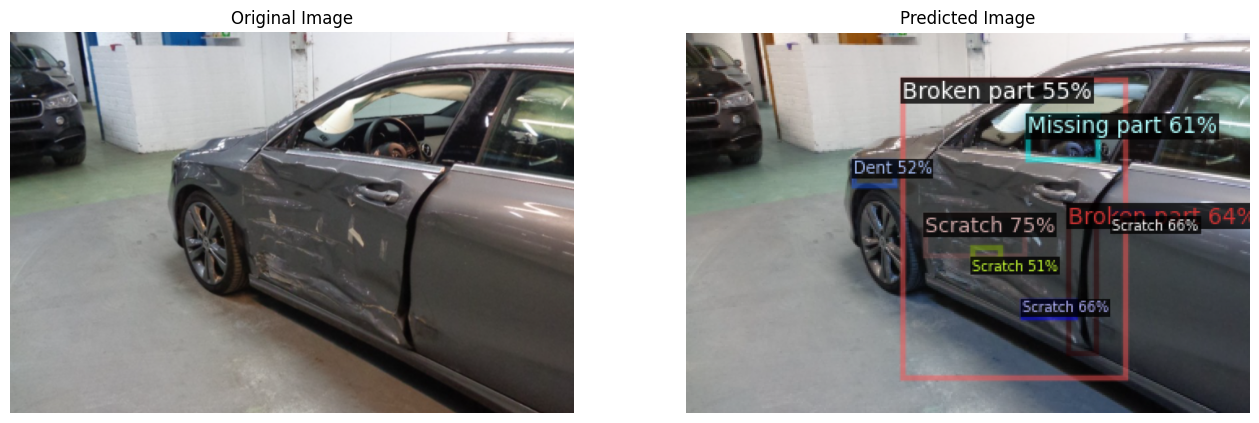

In [16]:
import cv2
import matplotlib.pyplot as plt
import torch

# Load image
im = cv2.imread('/kaggle/input/car-parts-and-car-damages/Car parts dataset/File1/img/Car damages 1080.png')


# Make predictions using the predictor
output = predictor(im)

# Extract bounding boxes, scores, and classes
boxes = output["instances"].pred_boxes.tensor.cpu()
scores = output["instances"].scores.cpu()
classes = output["instances"].pred_classes.cpu()

# Perform Non-Maximum Suppression (NMS) to merge overlapping boxes
keep = torch.ops.torchvision.nms(boxes, scores,0.1)

# Create a new Instances object with the NMS boxes
nms_instances = Instances(output["instances"].image_size)
nms_instances.pred_boxes = Boxes(boxes[keep])
nms_instances.scores = scores[keep]
nms_instances.pred_classes = classes[keep]

# Visualize original image
plt.subplot(1, 2, 1)
plt.imshow(im[:, :, ::-1])
plt.title('Original Image')
plt.axis('off')

# Draw the NMS predictions on the image
v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
out = v.draw_instance_predictions(nms_instances.to('cpu'))

# Show the image with predictions
plt.subplot(1, 2, 2)
plt.imshow(out.get_image()[:, :, ::-1])
plt.title('Predicted Image')
plt.axis('off')
plt.show()